# GaLore Memory Benchmark

This notebook verifies the memory savings of **GaLoreAdamW** compared to standard **AdamW**.

### ⚠️ Important Note
This benchmark trains a **freshly initialized Llama-125M model with Random Weights** for a few steps. 
It does **not** use your trained model checkpoint. 
This is intentional: using random weights allows us to measure pure optimizer memory usage in a noise-free, controlled environment without loading large datasets or checkpoints.

In [1]:
import torch
import torch.nn as nn
from transformers import LlamaConfig, LlamaForCausalLM
from galore.optimizer import GaLoreAdamW
import matplotlib.pyplot as plt
import gc
import time

# Force clean slate
torch.cuda.empty_cache()
gc.collect()

0

In [2]:
def measure_peak_memory(optimizer_name="adamw", use_quantized=False, steps=20):
    print(f"\n--- Benchmarking {optimizer_name} (Quantized={use_quantized}) ---")
    
    # 1. Init Model (Random Weights)
    config = LlamaConfig(
        vocab_size=32000,
        hidden_size=768,       # Llama-125M config
        intermediate_size=3072,
        num_hidden_layers=12,
        num_attention_heads=12,
        max_position_embeddings=1024
    )
    model = LlamaForCausalLM(config).to("cuda").to(torch.bfloat16)
    model.train()
    
    # 2. Init Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    if optimizer_name == "adamw":
        optimizer = torch.optim.AdamW(params, lr=1e-3)
    else:
        optimizer = GaLoreAdamW(params, lr=1e-3, rank=128, update_proj_gap=200, quantized=use_quantized)
    
    # 3. Dummy Data
    batch_size = 4
    seq_len = 512
    dummy_input = torch.randint(0, 32000, (batch_size, seq_len)).to("cuda")
    
    # 4. Training Loop
    torch.cuda.reset_peak_memory_stats()
    start_mem = torch.cuda.memory_allocated()
    
    start_time = time.time()
    for i in range(steps):
        optimizer.zero_grad()
        outputs = model(dummy_input, labels=dummy_input)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    peak_mem = torch.cuda.max_memory_allocated() / 1e9 # GB
    throughput = (batch_size * seq_len * steps) / (end_time - start_time)
    
    print(f"Peak Memory: {peak_mem:.2f} GB")
    print(f"Throughput: {throughput:.1f} tokens/sec")
    
    # Cleanup
    del model, optimizer, loss, outputs
    torch.cuda.empty_cache()
    gc.collect()
    
    return peak_mem, throughput

In [3]:
# Run Comparisons
mem_adam, t_adam = measure_peak_memory("adamw")
mem_galore, t_galore = measure_peak_memory("galore", use_quantized=False)
mem_galore_q, t_galore_q = measure_peak_memory("galore", use_quantized=True)


--- Benchmarking adamw (Quantized=False) ---
Peak Memory: 3.24 GB
Throughput: 8446.9 tokens/sec

--- Benchmarking galore (Quantized=False) ---
Peak Memory: 2.65 GB
Throughput: 3796.4 tokens/sec

--- Benchmarking galore (Quantized=True) ---
Peak Memory: 2.63 GB
Throughput: 2768.8 tokens/sec


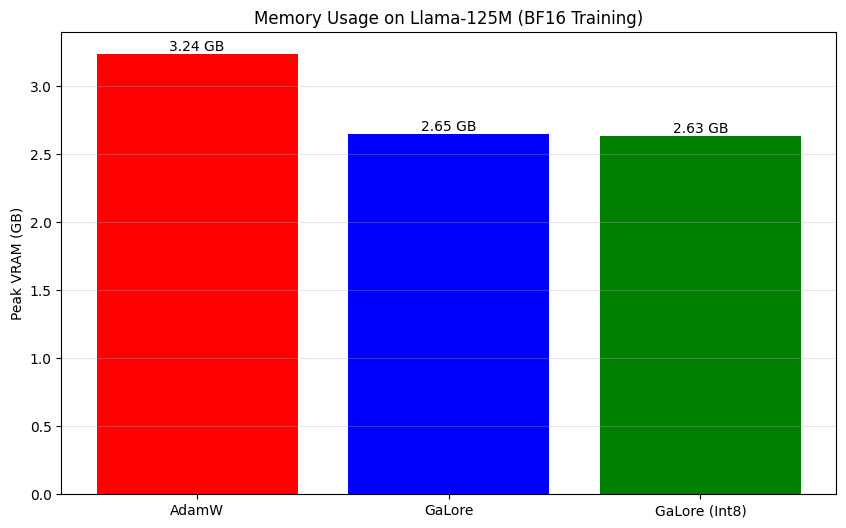

In [4]:
# Plotting
labels = ['AdamW', 'GaLore', 'GaLore (Int8)']
values = [mem_adam, mem_galore, mem_galore_q]
colors = ['red', 'blue', 'green']

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)
plt.ylabel('Peak VRAM (GB)')
plt.title('Memory Usage on Llama-125M (BF16 Training)')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f} GB', ha='center', va='bottom')

plt.show()